In [8]:
import pandas as pd
import numpy as np
# I made a change
#we are back in the original one

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [10]:
def drop_id(data):
    data.drop('id', axis = 1, inplace = True)

In [11]:
test_id = test['id']

In [12]:
data = [train, test]
for i in data:
    drop_id(i)

<Axes: >

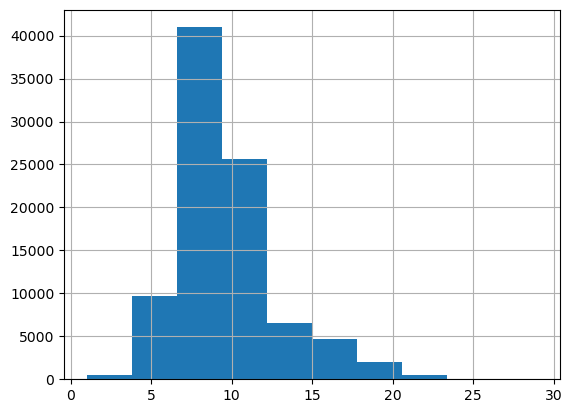

In [13]:
#Our y has a normal distribution so we do not need to transform it
train['Rings'].hist()

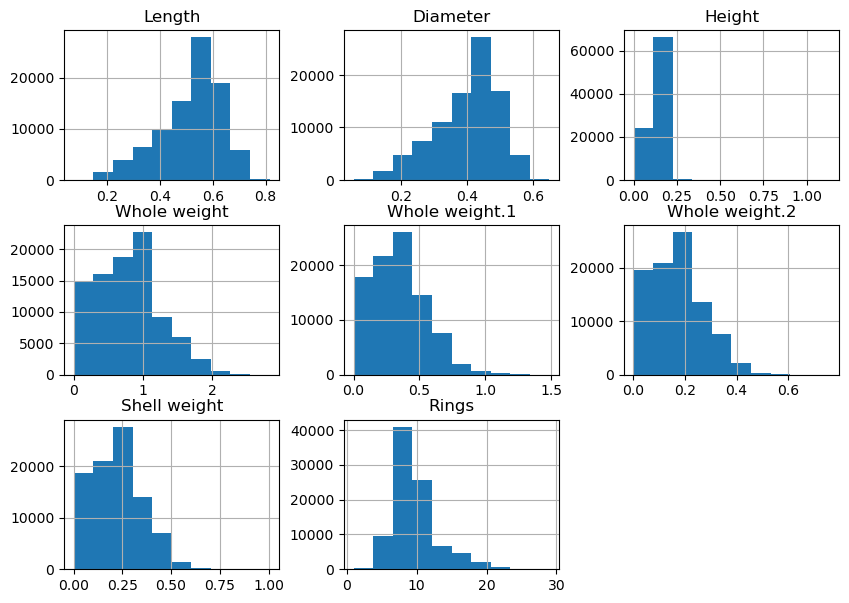

In [14]:
#we can see that our predictors are skewed, especially height might be problematic
train.hist(figsize = (10,7));

In [15]:
train.dtypes #only sex is categorical

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object

In [16]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
train = pd.concat([pd.DataFrame(encoder.fit_transform(train[['Sex']]).astype(int),columns = encoder.categories_[0]), 
                   train.iloc[:,1:]] ,axis = 1)


In [17]:
test = pd.concat([pd.DataFrame(encoder.transform(test[['Sex']]).astype(int), columns = encoder.categories_[0]),
                  test.iloc[:,1:]], axis= 1)


In [18]:
target = train['Rings']
train.drop('Rings', axis = 1, inplace = True)

In [19]:
cat_var = ["F","I","M"]
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()
column_names = train.iloc[:,3:len(train)-1].columns.tolist()
cont_train_scaled = scaler.fit_transform(train.iloc[:,3:])
train_scaled = pd.DataFrame(cont_train_scaled, columns = column_names)

In [20]:
column_names = test.iloc[:,3:].columns.tolist()
cont_test_scaled = scaler.transform(test.iloc[:,3:])
test_scaled = pd.DataFrame(cont_test_scaled, columns = column_names)

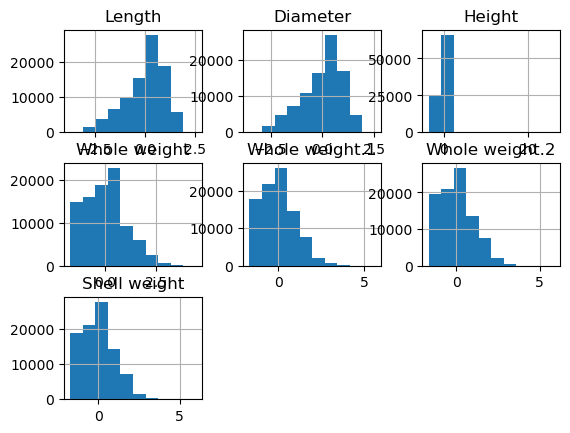

In [21]:
train_scaled.hist();

In [22]:
from scipy.stats import yeojohnson

transformed_train = train_scaled.copy()

for column in train_scaled.columns:
    transformed_train[column], _ = yeojohnson(train_scaled[column])

In [23]:
transformed_test = test_scaled.copy()

for column in test_scaled.columns:
    transformed_test[column], _ = yeojohnson(test_scaled[column])

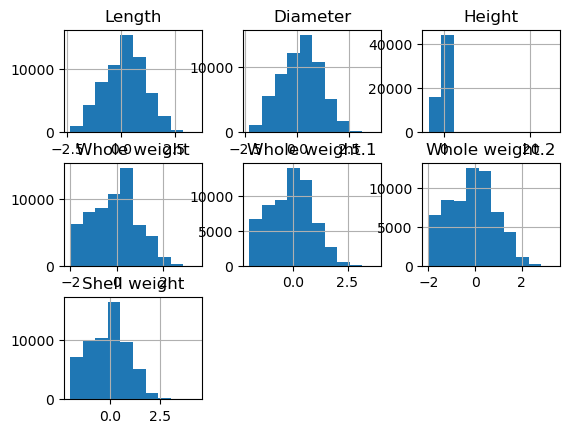

In [24]:
transformed_test.hist();

In [25]:
train_ready = pd.concat([train.iloc[:,:3], transformed_train], axis = 1)

In [26]:
test_ready = pd.concat([test.iloc[:,:3], transformed_test], axis = 1)

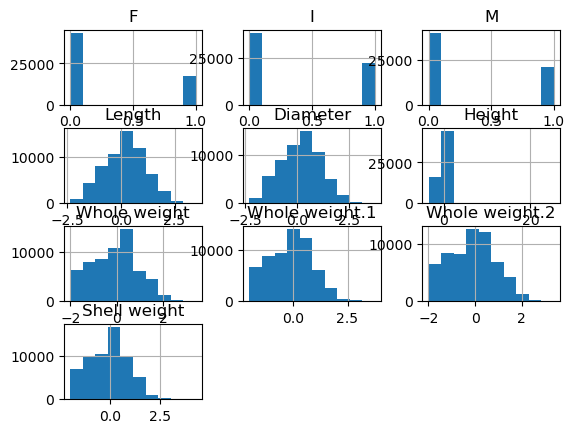

In [27]:
test_ready.hist();

<Axes: >

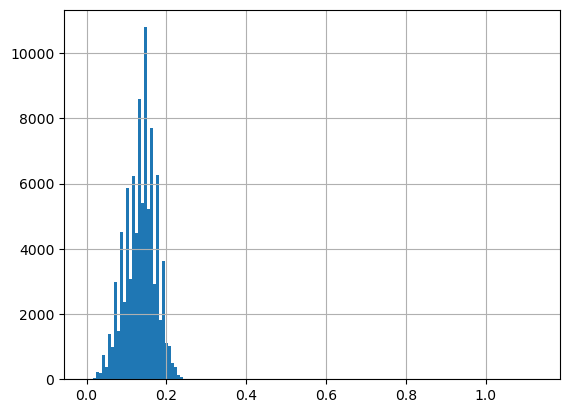

In [28]:
#height is also normally distributed
train['Height'].hist(bins = 150)

In [29]:
#transform the target
log_target = np.log(1+target)
#we will submit answer as np.exp(y) -1

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_ready, log_target, test_size = .2, random_state = 42)

In [31]:
X_train.shape

(72492, 10)

In [39]:
#Modeling plan, first check linaer regression, then different regression and apply regularizations
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [40]:
from sklearn.metrics import mean_squared_error
y = lin_reg.predict(X_val)
mean_squared_error(y_val,y,squared = False)

0.1706071103867941

In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
train_poly = poly_features.fit_transform(train_ready)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train_poly, log_target, test_size = .2, random_state = 42)

In [43]:
#polynomial terms seem to help
lin_reg.fit(X_train, y_train)
y = lin_reg.predict(X_val)
mean_squared_error(y_val,y,squared = False)

0.1583030446782785

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_ready, log_target, test_size = .2, random_state = 42)

In [45]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

SGDRegressor()

In [46]:
y = sgd.predict(X_val)
mean_squared_error(y_val,y,squared = False)

0.17120060302725448

In [54]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

gbr = GradientBoostingRegressor()
xgb = xgb.XGBRegressor()
cat = CatBoostRegressor(verbose = False)
rf = RandomForestRegressor()
hgbr = HistGradientBoostingRegressor()

In [55]:
models = [rf,gbr,xgb,cat,hgbr]
for num, model in enumerate(models):
    model.fit(X_train, y_train)
    y = model.predict(X_val)
    print("Model num: ", num, "RMSLE: ", mean_squared_error(y_val,y,squared = False))

Model num:  0 RMSLE:  0.15450850899777224
Model num:  1 RMSLE:  0.15534850969849495
Model num:  2 RMSLE:  0.1524429276685347
Model num:  3 RMSLE:  0.15096676834455663
Model num:  4 RMSLE:  0.1521249613868561


In [ ]:
#lets use xgb, cat, and hgbr

In [61]:
from sklearn.model_selection import KFold
def model_cv(X, y, model, cv=5):
        sf = KFold(n_splits = cv, shuffle = True, random_state = 42)
        scores = []
        for j, (train_index, valid_index) in enumerate(sf.split(X, y)):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_valid)
            scores = mean_squared_error(y_valid, y_pred, squared = False)
        return np.mean(scores)

In [94]:
import optuna
from xgboost import XGBRegressor
def objective_cat(trial, X, y):
    params = {
        "iterations": 1000,
        "loss_function":'RMSE',
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    scores = model_cv(X, y, model, cv = 5)
    return np.mean(scores) 

def createXGBoost(trial):
    params = {
        #'tree_method': 'hist',
        'n_estimators': trial.suggest_int('n_estimators',100, 1000),
        'max_depth': trial.suggest_int('max_depth',2, 20),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float("subsample", 0.05, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.05, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight',2, 20),
        'gamma': trial.suggest_float("gamma", 1e-2, 1.0),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42
    }
    
    return XGBRegressor(**params)

def objective_xgb(trial, X, y):
    model = createXGBoost(trial)
    scores = model_cv(X, y, model, cv = 5)
    return np.mean(scores)  

def objective_hgbr(trial, X, y):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        'max_iter': trial.suggest_int('max_iter',100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'l2_regularization':  trial.suggest_float('l2_regularization', 0, 0.3)
    }
    
    model = HistGradientBoostingRegressor(**params)
    scores = model_cv(train_ready,log_target, model, cv = 3)
    return np.mean(scores) 

In [62]:
study = optuna.create_study(study_name='optimization', direction='minimize')
study.optimize(lambda trial: objective_cat(trial, train_ready, log_target), n_trials=30)

[I 2024-04-03 21:41:15,214] A new study created in memory with name: optimization
[I 2024-04-03 21:41:19,746] Trial 0 finished with value: 0.18189836083636338 and parameters: {'learning_rate': 0.0031946878386478346, 'depth': 1, 'subsample': 0.6092500523757498, 'colsample_bylevel': 0.4668411352423189, 'min_data_in_leaf': 29}. Best is trial 0 with value: 0.18189836083636338.
[I 2024-04-03 21:41:31,009] Trial 1 finished with value: 0.14708433786078493 and parameters: {'learning_rate': 0.03659220888036592, 'depth': 6, 'subsample': 0.8903611757936537, 'colsample_bylevel': 0.48166751768543326, 'min_data_in_leaf': 88}. Best is trial 1 with value: 0.14708433786078493.
[I 2024-04-03 21:41:38,473] Trial 2 finished with value: 0.16276734224307743 and parameters: {'learning_rate': 0.00412854300840734, 'depth': 4, 'subsample': 0.6698140128060215, 'colsample_bylevel': 0.2963601123215244, 'min_data_in_leaf': 84}. Best is trial 1 with value: 0.14708433786078493.
[I 2024-04-03 21:41:42,285] Trial 3 fin

[I 2024-04-03 21:47:01,054] Trial 28 finished with value: 0.16737176684752503 and parameters: {'learning_rate': 0.001648607610323493, 'depth': 8, 'subsample': 0.663216922157397, 'colsample_bylevel': 0.5569346652266918, 'min_data_in_leaf': 11}. Best is trial 22 with value: 0.14650282313925034.
[I 2024-04-03 21:47:11,435] Trial 29 finished with value: 0.14671363299591375 and parameters: {'learning_rate': 0.06661300989916497, 'depth': 6, 'subsample': 0.6046428033922717, 'colsample_bylevel': 0.43975104091639217, 'min_data_in_leaf': 33}. Best is trial 22 with value: 0.14650282313925034.


In [91]:
study= optuna.create_study()
study.optimize(lambda trial: objective_hgbr(trial, train_ready, log_target), n_trials=30)

[I 2024-04-03 21:56:53,547] A new study created in memory with name: no-name-185ea554-be50-4196-a27a-e2e6f3f4683c
[I 2024-04-03 21:56:59,341] Trial 0 finished with value: 0.14796360068973308 and parameters: {'learning_rate': 0.030955345474821545, 'max_iter': 545, 'max_depth': 7, 'l2_regularization': 0.20527883563660596}. Best is trial 0 with value: 0.14796360068973308.
[I 2024-04-03 21:57:04,939] Trial 1 finished with value: 0.14829732627743905 and parameters: {'learning_rate': 0.022048114313114556, 'max_iter': 891, 'max_depth': 14, 'l2_regularization': 0.10974761359872215}. Best is trial 0 with value: 0.14796360068973308.
[I 2024-04-03 21:57:17,605] Trial 2 finished with value: 0.148637652154559 and parameters: {'learning_rate': 0.007826282815735625, 'max_iter': 822, 'max_depth': 11, 'l2_regularization': 0.15660489078793302}. Best is trial 0 with value: 0.14796360068973308.
[I 2024-04-03 21:57:29,006] Trial 3 finished with value: 0.15030147280240047 and parameters: {'learning_rate': 0

In [95]:
study = optuna.create_study(study_name='optimization_xgb', direction='minimize')
study.optimize(lambda trial: objective_xgb(trial, train_ready, log_target), n_trials=30)

[I 2024-04-03 22:00:37,092] A new study created in memory with name: optimization_xgb
[I 2024-04-03 22:00:44,455] Trial 0 finished with value: 0.15160234399433276 and parameters: {'n_estimators': 661, 'max_depth': 19, 'learning_rate': 0.003593104466870794, 'subsample': 0.6114570532962796, 'colsample_bytree': 0.5064714660271575, 'min_child_weight': 15, 'gamma': 0.26731833651818276}. Best is trial 0 with value: 0.15160234399433276.
[I 2024-04-03 22:00:46,919] Trial 1 finished with value: 0.1539128063017105 and parameters: {'n_estimators': 752, 'max_depth': 3, 'learning_rate': 0.028349051024936792, 'subsample': 0.7234856325206411, 'colsample_bytree': 0.20374735880457603, 'min_child_weight': 6, 'gamma': 0.5938912702893527}. Best is trial 0 with value: 0.15160234399433276.
[I 2024-04-03 22:00:54,717] Trial 2 finished with value: 0.15478771007859016 and parameters: {'n_estimators': 791, 'max_depth': 7, 'learning_rate': 0.0025820586006016287, 'subsample': 0.9064572856011937, 'colsample_bytree

[I 2024-04-03 22:03:01,754] Trial 24 finished with value: 0.148233804009236 and parameters: {'n_estimators': 788, 'max_depth': 13, 'learning_rate': 0.003139523885267722, 'subsample': 0.500042993092203, 'colsample_bytree': 0.8307686635531336, 'min_child_weight': 12, 'gamma': 0.07707230304505042}. Best is trial 16 with value: 0.14641455138476692.
[I 2024-04-03 22:03:06,348] Trial 25 finished with value: 0.1474706283112669 and parameters: {'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.006985750058853117, 'subsample': 0.4264110469293664, 'colsample_bytree': 0.5836257724473666, 'min_child_weight': 7, 'gamma': 0.20509976704730537}. Best is trial 16 with value: 0.14641455138476692.
[I 2024-04-03 22:03:12,742] Trial 26 finished with value: 0.14729849019923555 and parameters: {'n_estimators': 857, 'max_depth': 18, 'learning_rate': 0.004870644224666411, 'subsample': 0.32872180084610747, 'colsample_bytree': 0.917461029686047, 'min_child_weight': 9, 'gamma': 0.21390750277835696}. Best i

In [81]:
best_cat = CatBoostRegressor(**{'learning_rate': 0.06661300989916497, 'depth': 6, 
                                'subsample': 0.6046428033922717, 
                                'colsample_bylevel': 0.43975104091639217, 
                                'min_data_in_leaf': 33})

In [92]:
best_hgbr = HistGradientBoostingRegressor(**{'learning_rate': 0.023515188176562535, 'max_iter': 197, 
                                             'max_depth': 20, 'l2_regularization': 0.09769668750374104})

In [96]:
best_xgb = XGBRegressor(**{'n_estimators': 658, 'max_depth': 19, 'learning_rate': 0.003705697646979707, 
                           'subsample': 0.5864769798593579, 'colsample_bytree': 0.43466251314161497, 
                           'min_child_weight': 12, 'gamma': 0.28383171929488527})

In [147]:
best_cat.fit(X_train,y_train)
best_hgbr.fit(X_train,y_train)
best_xgb.fit(X_train,y_train)

xgb_pred = best_xgb.predict(X_val)
hgbr_pred = best_hgbr.predict(X_val)
cat_pred = best_cat.predict(X_val)

0:	learn: 0.2739141	total: 3.4ms	remaining: 3.4s
1:	learn: 0.2639560	total: 6.2ms	remaining: 3.09s
2:	learn: 0.2549528	total: 9.41ms	remaining: 3.13s
3:	learn: 0.2468054	total: 12.3ms	remaining: 3.06s
4:	learn: 0.2387770	total: 15.3ms	remaining: 3.04s
5:	learn: 0.2317669	total: 17.6ms	remaining: 2.91s
6:	learn: 0.2257098	total: 19.8ms	remaining: 2.81s
7:	learn: 0.2201195	total: 22ms	remaining: 2.73s
8:	learn: 0.2146808	total: 24.1ms	remaining: 2.65s
9:	learn: 0.2098483	total: 26.2ms	remaining: 2.6s
10:	learn: 0.2054996	total: 28.6ms	remaining: 2.57s
11:	learn: 0.2016802	total: 30.6ms	remaining: 2.52s
12:	learn: 0.1990514	total: 31.6ms	remaining: 2.4s
13:	learn: 0.1956409	total: 33.7ms	remaining: 2.37s
14:	learn: 0.1928945	total: 35.8ms	remaining: 2.35s
15:	learn: 0.1904307	total: 37.9ms	remaining: 2.33s
16:	learn: 0.1881030	total: 40.1ms	remaining: 2.32s
17:	learn: 0.1858832	total: 42.2ms	remaining: 2.3s
18:	learn: 0.1835465	total: 44.3ms	remaining: 2.29s
19:	learn: 0.1816585	total: 46

183:	learn: 0.1508954	total: 403ms	remaining: 1.78s
184:	learn: 0.1508761	total: 405ms	remaining: 1.78s
185:	learn: 0.1508514	total: 407ms	remaining: 1.78s
186:	learn: 0.1508367	total: 409ms	remaining: 1.78s
187:	learn: 0.1508004	total: 411ms	remaining: 1.78s
188:	learn: 0.1507666	total: 414ms	remaining: 1.77s
189:	learn: 0.1507410	total: 416ms	remaining: 1.77s
190:	learn: 0.1507288	total: 419ms	remaining: 1.77s
191:	learn: 0.1507131	total: 421ms	remaining: 1.77s
192:	learn: 0.1507023	total: 423ms	remaining: 1.77s
193:	learn: 0.1506685	total: 425ms	remaining: 1.77s
194:	learn: 0.1506376	total: 428ms	remaining: 1.76s
195:	learn: 0.1505931	total: 430ms	remaining: 1.76s
196:	learn: 0.1505669	total: 432ms	remaining: 1.76s
197:	learn: 0.1505417	total: 434ms	remaining: 1.76s
198:	learn: 0.1505376	total: 436ms	remaining: 1.75s
199:	learn: 0.1505119	total: 438ms	remaining: 1.75s
200:	learn: 0.1505036	total: 440ms	remaining: 1.75s
201:	learn: 0.1504705	total: 442ms	remaining: 1.75s
202:	learn: 

366:	learn: 0.1475798	total: 801ms	remaining: 1.38s
367:	learn: 0.1475770	total: 803ms	remaining: 1.38s
368:	learn: 0.1475675	total: 805ms	remaining: 1.38s
369:	learn: 0.1475466	total: 808ms	remaining: 1.38s
370:	learn: 0.1475338	total: 810ms	remaining: 1.37s
371:	learn: 0.1475255	total: 812ms	remaining: 1.37s
372:	learn: 0.1475058	total: 814ms	remaining: 1.37s
373:	learn: 0.1474931	total: 816ms	remaining: 1.36s
374:	learn: 0.1474740	total: 818ms	remaining: 1.36s
375:	learn: 0.1474631	total: 821ms	remaining: 1.36s
376:	learn: 0.1474427	total: 823ms	remaining: 1.36s
377:	learn: 0.1474285	total: 825ms	remaining: 1.36s
378:	learn: 0.1474117	total: 827ms	remaining: 1.35s
379:	learn: 0.1473996	total: 829ms	remaining: 1.35s
380:	learn: 0.1473919	total: 831ms	remaining: 1.35s
381:	learn: 0.1473871	total: 834ms	remaining: 1.35s
382:	learn: 0.1473773	total: 836ms	remaining: 1.35s
383:	learn: 0.1473671	total: 838ms	remaining: 1.34s
384:	learn: 0.1473576	total: 841ms	remaining: 1.34s
385:	learn: 

552:	learn: 0.1456596	total: 1.2s	remaining: 969ms
553:	learn: 0.1456417	total: 1.2s	remaining: 967ms
554:	learn: 0.1456304	total: 1.2s	remaining: 965ms
555:	learn: 0.1456266	total: 1.21s	remaining: 962ms
556:	learn: 0.1456153	total: 1.21s	remaining: 960ms
557:	learn: 0.1456035	total: 1.21s	remaining: 958ms
558:	learn: 0.1455929	total: 1.21s	remaining: 956ms
559:	learn: 0.1455828	total: 1.21s	remaining: 954ms
560:	learn: 0.1455743	total: 1.22s	remaining: 952ms
561:	learn: 0.1455626	total: 1.22s	remaining: 949ms
562:	learn: 0.1455548	total: 1.22s	remaining: 947ms
563:	learn: 0.1455412	total: 1.22s	remaining: 945ms
564:	learn: 0.1455354	total: 1.22s	remaining: 943ms
565:	learn: 0.1455284	total: 1.23s	remaining: 941ms
566:	learn: 0.1455220	total: 1.23s	remaining: 938ms
567:	learn: 0.1455186	total: 1.23s	remaining: 936ms
568:	learn: 0.1455079	total: 1.23s	remaining: 934ms
569:	learn: 0.1455004	total: 1.24s	remaining: 932ms
570:	learn: 0.1454910	total: 1.24s	remaining: 929ms
571:	learn: 0.1

736:	learn: 0.1442190	total: 1.6s	remaining: 570ms
737:	learn: 0.1442100	total: 1.6s	remaining: 568ms
738:	learn: 0.1442009	total: 1.6s	remaining: 565ms
739:	learn: 0.1441934	total: 1.6s	remaining: 563ms
740:	learn: 0.1441863	total: 1.6s	remaining: 561ms
741:	learn: 0.1441862	total: 1.6s	remaining: 558ms
742:	learn: 0.1441803	total: 1.61s	remaining: 556ms
743:	learn: 0.1441762	total: 1.61s	remaining: 554ms
744:	learn: 0.1441707	total: 1.61s	remaining: 552ms
745:	learn: 0.1441658	total: 1.61s	remaining: 550ms
746:	learn: 0.1441609	total: 1.62s	remaining: 548ms
747:	learn: 0.1441501	total: 1.62s	remaining: 546ms
748:	learn: 0.1441408	total: 1.62s	remaining: 543ms
749:	learn: 0.1441283	total: 1.62s	remaining: 541ms
750:	learn: 0.1441266	total: 1.63s	remaining: 539ms
751:	learn: 0.1441167	total: 1.63s	remaining: 537ms
752:	learn: 0.1441125	total: 1.63s	remaining: 535ms
753:	learn: 0.1441085	total: 1.63s	remaining: 533ms
754:	learn: 0.1440975	total: 1.63s	remaining: 530ms
755:	learn: 0.1440

925:	learn: 0.1429060	total: 2s	remaining: 160ms
926:	learn: 0.1428986	total: 2s	remaining: 157ms
927:	learn: 0.1428930	total: 2s	remaining: 155ms
928:	learn: 0.1428832	total: 2s	remaining: 153ms
929:	learn: 0.1428782	total: 2s	remaining: 151ms
930:	learn: 0.1428709	total: 2.01s	remaining: 149ms
931:	learn: 0.1428650	total: 2.01s	remaining: 147ms
932:	learn: 0.1428614	total: 2.01s	remaining: 145ms
933:	learn: 0.1428546	total: 2.02s	remaining: 142ms
934:	learn: 0.1428484	total: 2.02s	remaining: 140ms
935:	learn: 0.1428439	total: 2.02s	remaining: 138ms
936:	learn: 0.1428334	total: 2.02s	remaining: 136ms
937:	learn: 0.1428269	total: 2.02s	remaining: 134ms
938:	learn: 0.1428226	total: 2.03s	remaining: 132ms
939:	learn: 0.1428174	total: 2.03s	remaining: 129ms
940:	learn: 0.1428122	total: 2.03s	remaining: 127ms
941:	learn: 0.1428045	total: 2.03s	remaining: 125ms
942:	learn: 0.1427935	total: 2.04s	remaining: 123ms
943:	learn: 0.1427862	total: 2.04s	remaining: 121ms
944:	learn: 0.1427826	total

In [138]:
pred = (xgb_pred+hgbr_pred+cat_pred)/3
pred = np.exp(pred) - 1

In [153]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from functools import partial

initial_weights = np.array([1/2, 1/2])

def calculate_rmse(weights, preds_1, preds_2, target):
    # Normalize weights
    weights /= np.sum(weights)
    
    # Calculate weighted sum
    weighted_sum = preds_1 * weights[0] + preds_2 * weights[1] 
    
    # Calculate RMSE
    rmse = mean_squared_error(target,weighted_sum,squared = False)
    
    return rmse

bounds = [(0, None), (0, None)]


result = minimize(partial(calculate_rmse, 
                  preds_1=xgb_pred,
                  preds_2 = cat_pred,
                  target=y_val), 
          initial_weights, 
          method='Nelder-Mead',
          bounds=bounds)

# Normalize optimal weights
optimal_weights = result.x / np.sum(result.x)


In [154]:
optimal_weights

array([0., 1.])

In [139]:
pred.shape

(60411,)

In [140]:
test_id.shape

(60411,)

In [141]:
submission = pd.concat([pd.DataFrame(test_id), pd.DataFrame(pred, columns = [target.name])], axis = 1)

In [142]:
submission.to_csv("submission_equal_blend.csv", sep = ',', index = False)